In [1]:
import numpy as np
import common
import matplotlib.pyplot as plt
import gpflow
%load_ext autoreload
%autoreload 2
plt.rcParams["font.size"] = 30
np.random.seed(100)

/Users/kumada/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/multipledispatch/dispatcher.py:24: AmbiguityWarning: 
Ambiguities exist in dispatched function _expectation

The following signatures may result in ambiguous behavior:
	[Gaussian, Linear, NoneType, Sum, InducingPoints], [Gaussian, Identity, NoneType, Kernel, InducingPoints]


Consider making the following additions:

@dispatch(Gaussian, Identity, NoneType, Sum, InducingPoints)
def _expectation(...)
  warn(warning_text(dispatcher.name, ambiguities), AmbiguityWarning)


GPflowはGPyをTensorFlowを用いて再実装したもの。これにより変分推論やMCMCができるようになった。

In [2]:
xs, ys = common.generate_observed_dataset()

In [3]:
real_xs, real_ys = common.generate_real_dataset()

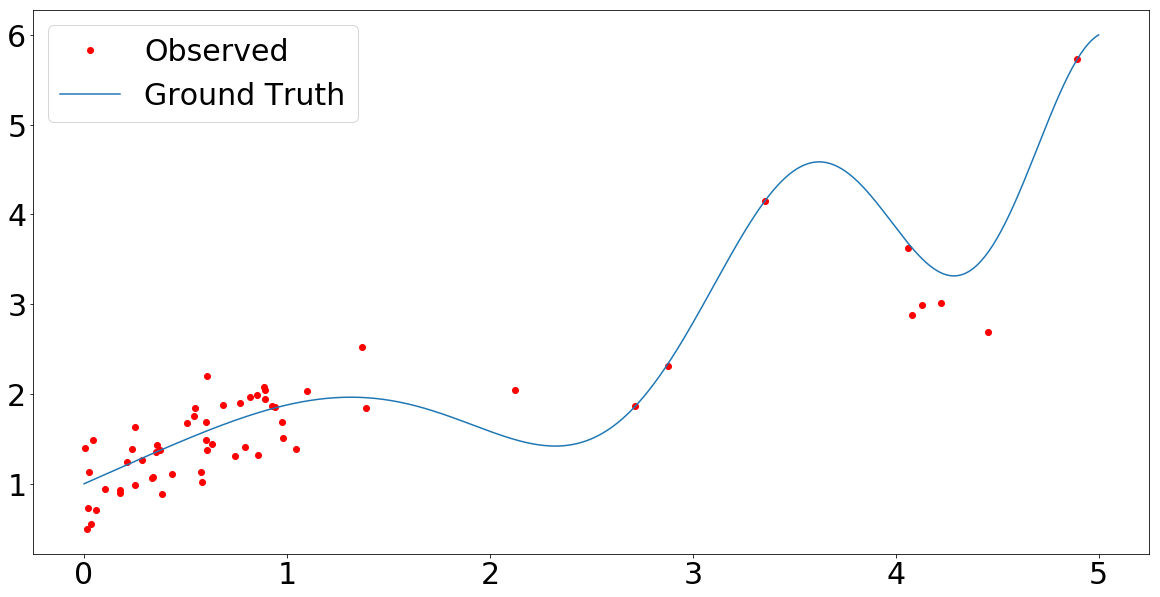

In [4]:
plt.figure(figsize=(20, 10))
plt.plot(xs, ys, "ro", label="Observed")
plt.plot(real_xs, real_ys, label="Ground Truth")
plt.legend(loc="best")
plt.show()

In [5]:
xs = xs.reshape(-1, 1)
ys = np.array(ys).reshape(-1, 1)
print(xs.shape, ys.shape)

(60, 1) (60, 1)


scikit-learnのときは3つのカーネルを重ね合わせた。
- ConstantKernel()：振幅を制御 
- Matern(length_scale=2, nu=3/2)：
- WhiteKernel(noise_level=1)：観測ノイズを制御

GPFlowでは一つのカーネルで良い。GPflowはベイズ推定を行う。非ガウス型関数の場合は変分推論あるいはMCMCを用いて近似計算が実行される。

In [6]:
with gpflow.defer_build():
    # input_dim: 入力データの次元
    # variance: 分散の初期値
    # lengthscale: 長さスケールの初期値
    k = gpflow.kernels.Matern32(input_dim=1, variance=1, lengthscales=1.2)
    m = gpflow.models.gpr.GPR(xs, ys, kern=k)
    m.likelihood.variance = 0.01

必要であれば事前分布もここで設定することができる。何も設定しない場合は最尤法が適用される。

In [7]:
# モデルの内容確認
m.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
GPR/kern/lengthscales,Parameter,None,+ve,True,(),True,1.2
GPR/kern/variance,Parameter,None,+ve,True,(),True,1.0
GPR/likelihood/variance,Parameter,None,+ve,True,(),True,0.01


In [8]:
# これは一体なんだ？
# 解説https://gpflow.readthedocs.io/en/latest/notebooks/models.html#にある
# Constraints and trainable variablesとは何だ？
# 訓練で決めるか否かを見ているのだろう。
# どの変数を訓練で決め、どの変数をハイパーパラメータとするかを自由に設定できるということだろう。
m.read_trainables()

{'GPR/kern/lengthscales': array(1.2),
 'GPR/kern/variance': array(1.),
 'GPR/likelihood/variance': array(0.01)}

In [9]:
# tensorflowを使うのでグラフの解釈を行う。
m.compile()

# 最適化器を作成
opt = gpflow.train.ScipyOptimizer()

# 最適化を実行。
opt.minimize(m)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 37.973608
  Number of iterations: 20
  Number of functions evaluations: 21


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 37.973608
  Number of iterations: 20
  Number of functions evaluations: 21


In [10]:
# 未知データxのyを予測する。
x_pred = np.linspace(0, 5, 1000).reshape(-1,1)
y_pred, sigma = m.predict_y(x_pred)

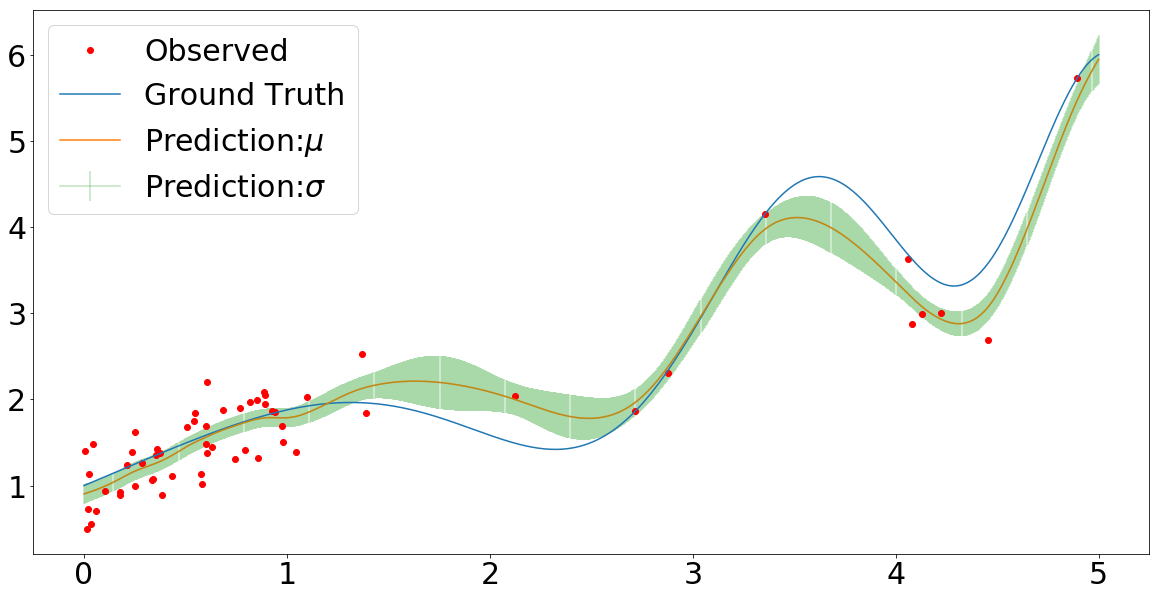

In [12]:
plt.figure(figsize=(20, 10))
plt.plot(xs, ys, "ro", label="Observed")
plt.plot(real_xs, real_ys, label="Ground Truth")
plt.plot(x_pred, y_pred, label="Prediction:$\mu$")
plt.errorbar(x_pred, y_pred, yerr=sigma, label="Prediction:$\sigma$", alpha = 0.3)
plt.legend(loc="best")
plt.show()